In [194]:
# Read file
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel (r'SDU_Task_Excel.docx.xlsx')
print(df.shape)
df.head() # Size

(178, 10)


,Project_ID,Project_Acronym,Project_Keywords,Project_Title,Project_Abstract,Call_ID,Coord_Institution,Coord_Institution_Country,Status,Project_Budget
0,814437,4CWhite,fish whitefish processing,The First High-Precision Computer-Controlled C...,"Our company, CURIO ltd., founded in 2007, is o...",EIC-SMEInst-2018-2020,Curio Ehf,IS,Closed,50000.00
1,857034,5G-HEART,aquaculture,5G Health Aquaculture And Transport Validation...,"Healthcare, transport and food verticals are h...",ICT-19-2019,Teknologian Tutkimuskeskus Vtt Oy,FI,Signed,14322073.75
2,745668,ABACUS,industry algae,Algae For A Biomass Applied To The Production ...,"ABACUS gathers 2 large industries, 3 algae SME...",BBI-2016-R09,Commissariat A L Energie Atomique Et Aux Energ...,FR,Signed,4653658.66
3,744603,Accordion Bioreactor,algae,An Innovative High Capacity Accordion Bioreact...,Access to vital raw ingredients for food/feed ...,SMEInst-08-2016-2017,Biopharmia As,NO,Closed,50000.00
4,887259,ALEHOOP,algae,Biorefineries For The Valorisation Of Macroalg...,ALEHOOP provides the demonstration at pilot sc...,BBI-2019-SO3-D3,Contactica S.L.,ES,Signed,5140274.41


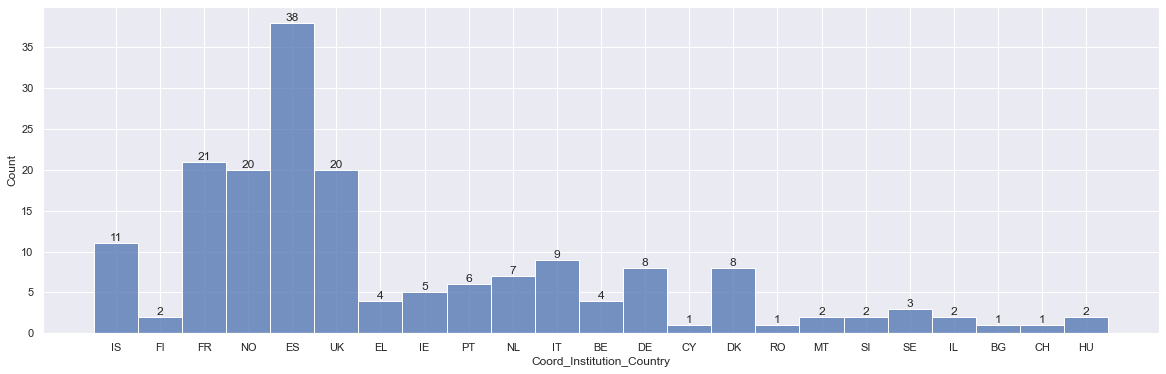

In [182]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})
y = sns.histplot(data=df, x="Coord_Institution_Country", binwidth=3);
labels = []
for p in y.patches:
    h = p.get_height()
    labels.append(str(h) if h else '')

y.bar_label(y.containers[0], labels=labels)
sns.set(rc={'figure.figsize':(20,7)})


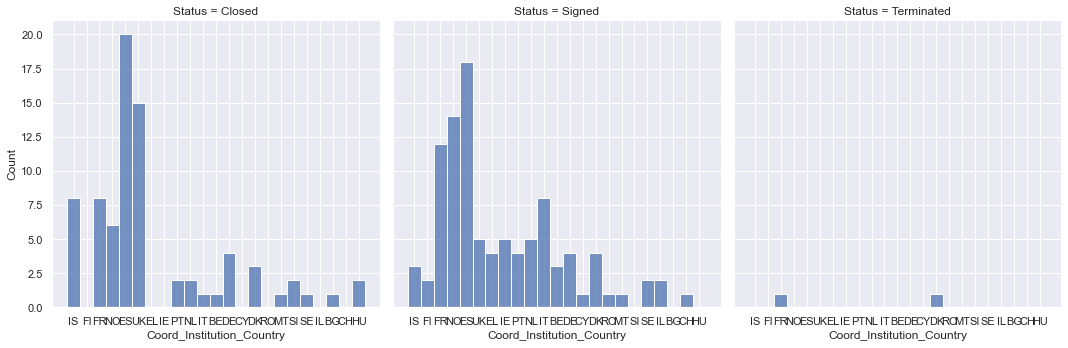

In [187]:
sns.set(rc={'figure.figsize':(20,5)})
sns.displot(df, x="Coord_Institution_Country", col="Status", bins=50);

### Exploratory Analysis
##### Let's visualize the most popular words for each category using word clouds.

In [189]:
import wordcloud

def show_wordcloud(data_signed_or_closed, title, clean_or_unclean):
    text = ' '.join(data_signed_or_closed[clean_or_unclean].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

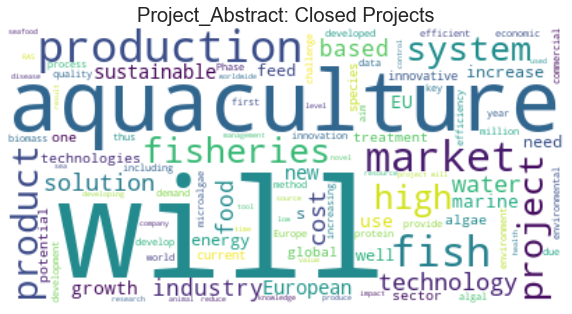

In [191]:
show_wordcloud(df[df.Status=='Closed'], "Project_Abstract: Closed Projects", "Project_Abstract")

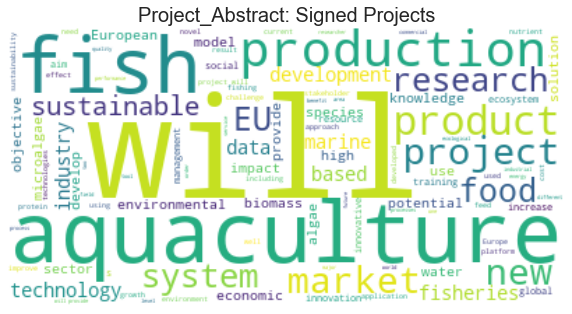

In [192]:
show_wordcloud(df[df.Status=='Signed'], "Project_Abstract: Signed Projects", "Project_Abstract")

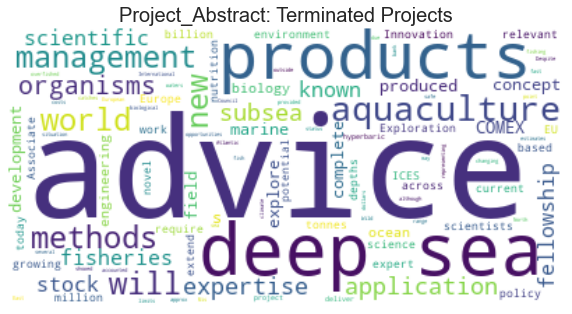

In [193]:
show_wordcloud(df[df.Status=='Terminated'], "Project_Abstract: Terminated Projects", "Project_Abstract")

We can see that "Will" is one of the most used words in both Closed and Signed projects_Abstracts, which indicates that cleaning would be a good idea before getting any idea, so lets clean the abstract text and check again

### Text Cleaning

First, we need to do some text cleaning, commonly referred to as "normalization". Text preprocessing/cleaning is usually the most crucial and time-consuming part of the NLP pipeline. for now I, will include the following simple steps to clean:

1. Removing punctuation
2. Converting text to lowercase 
3. Removing stopwords 
4. Stemming or lemmatizing

In [196]:
from sklearn.feature_extraction import _stop_words # getting list of stop words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mitha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mitha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [197]:
def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # stemming / lematizing
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [198]:
df['Cleaned_Abstract'] = df['Project_Abstract'].apply(text_processing) # produce clean Abstract

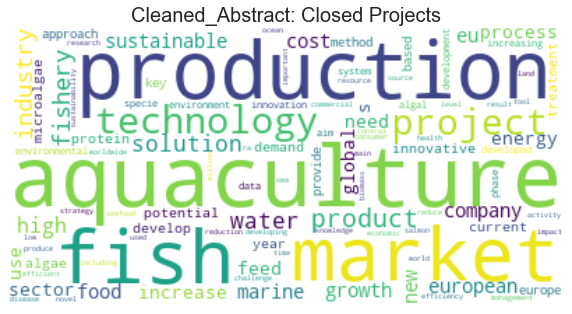

In [201]:
# Lets check agian with cleaned Abstract
show_wordcloud(df[df.Status=='Closed'], "Cleaned_Abstract: Closed Projects", 'Cleaned_Abstract')

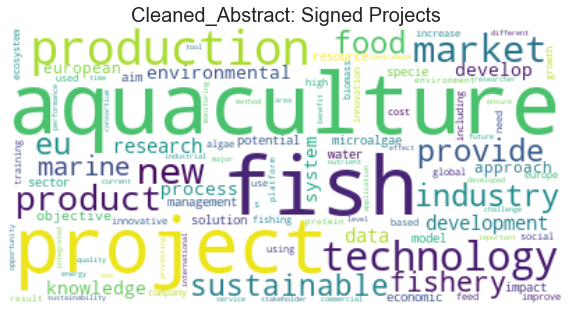

In [202]:
show_wordcloud(df[df.Status=='Signed'], "Cleaned_Abstract: Signed Projects", 'Cleaned_Abstract')

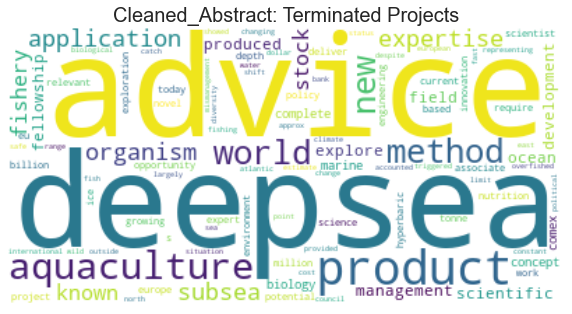

In [203]:
show_wordcloud(df[df.Status=='Terminated'], "Cleaned_Abstract: Terminated Projects", 'Cleaned_Abstract')

## Prepare data for LDA Analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. 

In [204]:
data = df.Cleaned_Abstract.values.tolist()

In [205]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [206]:
data_words = list(sent_to_words(data))

In [207]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:50])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 5), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 9), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1)]


In [208]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"fish" + 0.008*"production" + 0.008*"aquaculture" + 0.007*"market" + '
  '0.007*"project" + 0.007*"product" + 0.004*"high" + 0.004*"cost" + '
  '0.004*"industry" + 0.003*"fishery"'),
 (1,
  '0.013*"fish" + 0.009*"aquaculture" + 0.009*"project" + 0.008*"fishery" + '
  '0.007*"production" + 0.007*"market" + 0.006*"technology" + 0.006*"product" '
  '+ 0.005*"new" + 0.005*"marine"'),
 (2,
  '0.011*"water" + 0.010*"aquaculture" + 0.009*"technology" + 0.008*"industry" '
  '+ 0.008*"market" + 0.007*"production" + 0.006*"project" + 0.005*"new" + '
  '0.005*"feed" + 0.005*"food"'),
 (3,
  '0.011*"fish" + 0.009*"aquaculture" + 0.006*"food" + 0.006*"technology" + '
  '0.005*"production" + 0.005*"marine" + 0.005*"fishery" + 0.005*"market" + '
  '0.005*"research" + 0.005*"european"'),
 (4,
  '0.009*"aquaculture" + 0.008*"production" + 0.007*"project" + 0.006*"fish" + '
  '0.006*"sector" + 0.005*"market" + 0.004*"solution" + 0.004*"technology" + '
  '0.004*"high" + 0.004*"industry"'),


In [217]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_Done = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
#LDAvis_Done

In [218]:
pyLDAvis.save_html(LDAvis_prepared, 'LDAVis.html')

In [221]:
from IPython.display import HTML
display(HTML(filename='LDAVis.html'))